In [1]:
import os
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf 


In [2]:
import PIL
print(PIL.__version__)

8.2.0


In [ ]:
# Si pillow == 8.3.0 hacer un downgrade para no tener
# TypeError: __array__() takes 1 positional argument but 2 were given (Image classification Keras)
!pip install pillow==8.2.0

In [3]:
# Vemos si la GPU esta activada

physical_devices = tf.config.list_physical_devices('GPU')
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print("Num GPUs:", len(physical_devices))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1070, pci bus id: 0000:07:00.0, compute capability: 6.1

Num GPUs: 1


In [4]:
# Cargamos las carpetas de train y test en las variables

train_dir = 'train'
val_dir = 'test'

In [5]:
# Ver cuantas clases de emociones hay

emociones = os.listdir(train_dir)
print("Cantidad de tipos de emociones:", len(emociones))

Cantidad de tipos de emociones: 6


In [6]:
# Ver que clases de emociones existen

os.listdir(train_dir)

['angry', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

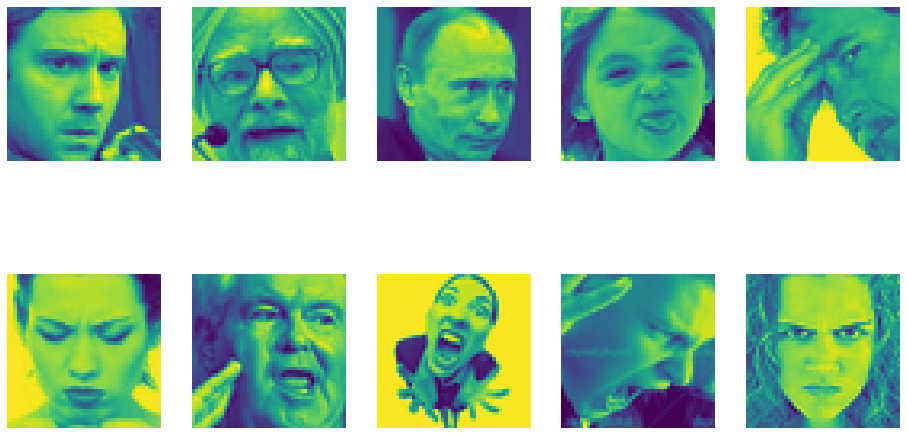

In [7]:
# Visualizar las 10 primeras imagenes de emociones

files = glob(train_dir + "/" + emociones[0] + "/**.png")

fig = plt.figure(figsize=(16,9))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.axis('off')
    img = mpimg.imread(files[i])
    plt.imshow(img)
    
plt.show()

In [8]:
# Visualizar la dimension de la primera imagen

img = mpimg.imread(files[0])
img.shape

(48, 48)

In [9]:
# Visualizar como están representados los pixeles (0 a 1)

print(img[30, 15:30])

[0.654902   0.654902   0.63529414 0.59607846 0.5254902  0.4509804
 0.49411765 0.46666667 0.41568628 0.3882353  0.42745098 0.5529412
 0.61960787 0.5882353  0.60784316]


[('angry', 3995), ('fearful', 4097), ('happy', 7215), ('neutral', 4965), ('sad', 4830), ('surprised', 3171)]


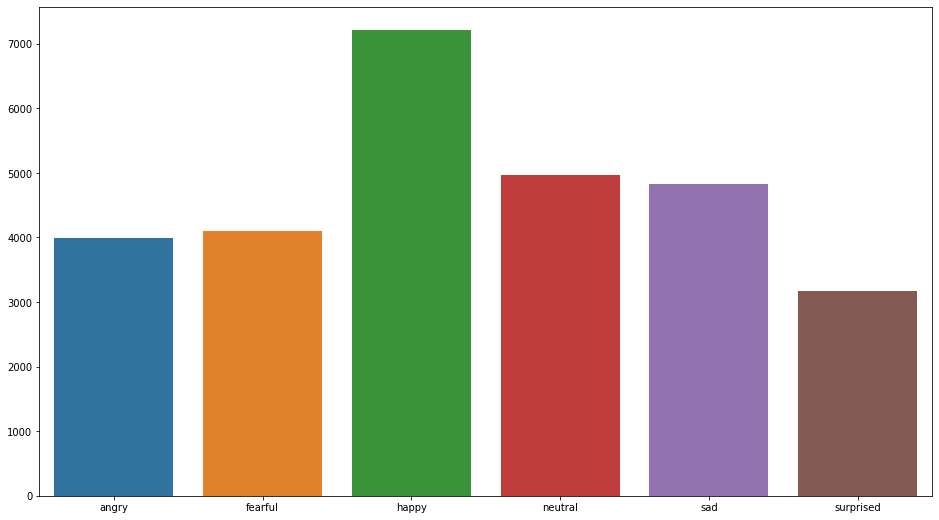

In [10]:
# Analizar cuantas emociones hay de cada una

nombre_emociones = []
cantidad_emociones = []
for emocion in emociones:
    nombre_emocion = emocion.split("_")[0]
    files = glob(train_dir + "/" + emocion + "/**.png")
    nombre_emociones.append(nombre_emocion)
    cantidad_emociones.append(len(files))

emociones = zip(nombre_emociones, cantidad_emociones)
zipped_list = list(emociones)

print(zipped_list)
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot()
sns.barplot(x=nombre_emociones, y=cantidad_emociones, ax=ax)
plt.show()

In [92]:
# Creamos generadores, train y test
# Se probaron diferentes batch_size, rotation_range, zoom_range, horizontal_flip,
# sin diferencias. El dataset es chico.

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        # Para modelo Sequential
        target_size=(48, 48),
        # Para modelo InceptionV3 minimo input size 75x75
        # target_size=(75, 75),
        batch_size=64,
        # Para modelo Sequential 1 canal(GRAYSCALE)
        color_mode="grayscale",
        # VGG16, ResNet50, InceptionV3 aceptan 3 canales(RGB)
        # color_mode="rgb",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        # Para modelo Sequential
        target_size=(48, 48),
        # Para modelo InceptionV3 minimo input size 75x75
        # target_size=(75, 75),
        batch_size=64,
        # Para modelo Sequential 1 canal(GRAYSCALE)
        color_mode="grayscale",
        # VGG16, ResNet50, InceptionV3 aceptan 3 canales(RGB)
        # color_mode="rgb",
        class_mode='categorical')


Found 28273 images belonging to 6 classes.
Found 7067 images belonging to 6 classes.


In [93]:
batch_imagenes, batch_clases = train_generator.next()

In [94]:
batch_imagenes.shape

(64, 48, 48, 1)

In [95]:
batch_clases.shape

(64, 6)

In [96]:
print("Cantidad de imagenes en el batch:", batch_imagenes.shape[0])
print("Dimensión de la imagen:", batch_imagenes.shape[1:])

Cantidad de imagenes en el batch: 64
Dimensión de la imagen: (48, 48, 1)


In [97]:
print("Cantidad de clases/emociones:", batch_clases.shape[1])

Cantidad de clases/emociones: 6


In [98]:
steps_per_epoch_train = len(train_generator)
steps_per_epoch_train

442

In [99]:
steps_per_epoch_validation = len(validation_generator)
steps_per_epoch_validation

111

In [100]:
in_shape = batch_imagenes.shape[1:]
in_shape

(48, 48, 1)

In [101]:
out_shape = batch_clases.shape[1]
out_shape

6

In [ ]:
from tensorflow.keras.applications import Xception

# Traemos el modelo Xception pre entrenado con los pesos obtenidos del dataset de ImageNet
# Indicamos que no deseamos las ultimas capas de clasificación de la red (include_top=False)
# Indicamos que no deseamos que los pesos de la red sean entrenados (xception_base.trainable=False)
# Overfitting , datset chico para un modelo enorme
xception_base = Xception(weights='imagenet',
                    include_top=False,
                    input_shape=in_shape,
                    )
xception_base.trainable=False
xception_base.summary()

In [ ]:
from tensorflow.keras.applications import InceptionV3

# Traemos el modelo InceptionV3 pre entrenado con los pesos obtenidos del dataset de ImageNet
# Indicamos que no deseamos las ultimas capas de clasificación de la red (include_top=False)
# Indicamos que no deseamos que los pesos de la red sean entrenados (inception_v3_base.trainable=False)
# Overfitting , datset chico para un modelo enorme

inception_v3_base = InceptionV3(weights='imagenet',
                    include_top=False,
                    input_shape=in_shape,
                    )
inception_v3_base.trainable=False
inception_v3_base.summary()

In [ ]:
from tensorflow.keras.applications import ResNet50

# Traemos el modelo ResNet50 pre entrenado con los pesos obtenidos del dataset de ImageNet
# Indicamos que no deseamos las ultimas capas de clasificación de la red (include_top=False)
# Indicamos que no deseamos que los pesos de la red sean entrenados (resnet_base.trainable=False)

resnet_base = ResNet50(weights='imagenet',
                      include_top=False,
                      input_shape=in_shape
                      )
resnet_base.trainable=False
resnet_base.summary()

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import VGG16

# Traemos el modelo VGG16 pre entrenado con los pesos obtenidos del dataset de ImageNet
# Indicamos que no deseamos las ultimas capas de clasificación de la red (include_top=False)
# Indicamos que no deseamos que los pesos de la red sean entrenados (vgg_base.trainable=False)

vgg_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=in_shape
                )
vgg_base.trainable=False
vgg_base.summary()

In [ ]:
# Modelo Sequential + Xception
# Modelo Sequential + InceptionV3
# Modelo Sequential + ResNet50
# Modelo Sequential + VGG16

model = Sequential()
# model.add(xception_base)
# model.add(inception_v3_base)
# model.add(resnet_base)
# model.add(vgg_base)

# Aplanamos la salida.
model.add(Flatten())

# ResNet50 y Xception despues del Flatten deben ir directo a la ultima 
# capa conectada ( model.add(Dense(units=out_shape, activation='softmax'))), 
# de lo ocontrario hay overfitting desde el comienzo. 

# Primera capa completamente conectada con activacion relu.
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.8))
model.add(Dense(units=256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.2))

# Última capa totalmente conectada con activación de softmax para la deteccion de emociones.
model.add(Dense(units=out_shape, activation='softmax'))

model.summary()

In [ ]:
# Modelo Sequential
# El input size es (48, 48, 1)
# Utilizamos capas de convulcion Conv2D con activacion relu y BatchNormalization , despues MaxPooling y Dropout
# Aplanamos con Flatten, por ultimo una capa con activación softmax para la deteccion de emociones.
# Este modelo es el que mejor resultado da.

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu", input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(out_shape, activation="softmax"))

model.summary()

In [103]:
# Compilamos el modelo

model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

emocion_model_info = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch_train,
        epochs=200,
        validation_data=validation_generator,
        validation_steps=steps_per_epoch_validation)

Epoch 1/200
442/442 [==============================] - 19s 27ms/step - loss: 1.9082 - accuracy: 0.2915 - val_loss: 1.7194 - val_accuracy: 0.2713
Epoch 2/200
442/442 [==============================] - 12s 26ms/step - loss: 1.4851 - accuracy: 0.4138 - val_loss: 1.3565 - val_accuracy: 0.4670
Epoch 3/200
442/442 [==============================] - 12s 26ms/step - loss: 1.3545 - accuracy: 0.4666 - val_loss: 1.2548 - val_accuracy: 0.5083
Epoch 4/200
442/442 [==============================] - 12s 26ms/step - loss: 1.2859 - accuracy: 0.4956 - val_loss: 1.2187 - val_accuracy: 0.5206
Epoch 5/200
442/442 [==============================] - 12s 26ms/step - loss: 1.2477 - accuracy: 0.5174 - val_loss: 1.3176 - val_accuracy: 0.4749
Epoch 6/200
442/442 [==============================] - 12s 26ms/step - loss: 1.2057 - accuracy: 0.5328 - val_loss: 1.1269 - val_accuracy: 0.5595
Epoch 7/200
442/442 [==============================] - 12s 26ms/step - loss: 1.1638 - accuracy: 0.5529 - val_loss: 1.1577 - val_ac

442/442 [==============================] - 12s 26ms/step - loss: 0.5120 - accuracy: 0.8102 - val_loss: 1.0325 - val_accuracy: 0.6697
Epoch 114/200
442/442 [==============================] - 12s 26ms/step - loss: 0.5114 - accuracy: 0.8119 - val_loss: 1.0244 - val_accuracy: 0.6668
Epoch 115/200
442/442 [==============================] - 12s 26ms/step - loss: 0.4976 - accuracy: 0.8136 - val_loss: 1.0307 - val_accuracy: 0.6703
Epoch 116/200
442/442 [==============================] - 12s 26ms/step - loss: 0.5069 - accuracy: 0.8129 - val_loss: 1.0292 - val_accuracy: 0.6721
Epoch 117/200
442/442 [==============================] - 12s 27ms/step - loss: 0.5115 - accuracy: 0.8118 - val_loss: 1.0447 - val_accuracy: 0.6707
Epoch 118/200
442/442 [==============================] - 11s 26ms/step - loss: 0.5026 - accuracy: 0.8124 - val_loss: 1.0531 - val_accuracy: 0.6700
Epoch 119/200
442/442 [==============================] - 11s 26ms/step - loss: 0.5059 - accuracy: 0.8112 - val_loss: 1.0276 - val_ac

Epoch 169/200
442/442 [==============================] - 11s 26ms/step - loss: 0.4495 - accuracy: 0.8351 - val_loss: 1.0630 - val_accuracy: 0.6760
Epoch 170/200
442/442 [==============================] - 11s 26ms/step - loss: 0.4312 - accuracy: 0.8403 - val_loss: 1.0931 - val_accuracy: 0.6727
Epoch 171/200
442/442 [==============================] - 11s 26ms/step - loss: 0.4377 - accuracy: 0.8371 - val_loss: 1.0902 - val_accuracy: 0.6717
Epoch 172/200
442/442 [==============================] - 11s 26ms/step - loss: 0.4365 - accuracy: 0.8406 - val_loss: 1.0730 - val_accuracy: 0.6717
Epoch 173/200
442/442 [==============================] - 11s 26ms/step - loss: 0.4334 - accuracy: 0.8402 - val_loss: 1.0768 - val_accuracy: 0.6666
Epoch 174/200
442/442 [==============================] - 11s 26ms/step - loss: 0.4267 - accuracy: 0.8429 - val_loss: 1.0857 - val_accuracy: 0.6789
Epoch 175/200
442/442 [==============================] - 11s 26ms/step - loss: 0.4345 - accuracy: 0.8422 - val_loss: 1

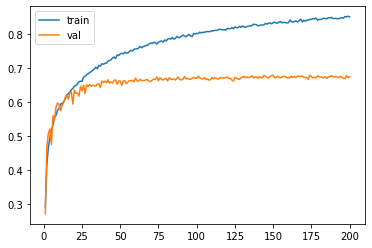

In [104]:
epoch_count = range(1, len(emocion_model_info.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=emocion_model_info.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=emocion_model_info.history['val_accuracy'], label='val')
plt.show()

In [108]:
# Guardamos el modelo

model.save('emocion_model.h5')

In [7]:
# Cargamos el modelo

from tensorflow.keras import models
emocion_model = models.load_model('emocion_model.h5')

In [10]:
def emocion(emotions):
    x = ('Enojado', 'Miedoso', 'Feliz', 'Neutro', 'Triste', 'Sorprendido' )
    y = np.arange(len(x))
    
    plt.subplots(figsize=(9, 4))
    plt.bar(y, emotions, align='center', alpha=0.5)
    plt.xticks(y, x)
    plt.ylabel('Porcentaje')
    plt.title('Sentimientos')
    
    plt.show()

In [11]:
import cv2
            
def cara(image):  
    facedata = 'haarcascade_frontalface_alt.xml'
    cascade = cv2.CascadeClassifier(facedata)

    img = cv2.imread(image)

    try:
    
        minisize = (img.shape[1],img.shape[0])
        miniframe = cv2.resize(img, minisize)

        faces = cascade.detectMultiScale(miniframe)

        for face in faces:
            x, y, w, h = [ v for v in face ]
            cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

            sub_face = img[y:y+h, x:x+w]
            
            cv2.imwrite('cara_cortada.jpg', sub_face)
           

    except Exception as e:
        print (e)


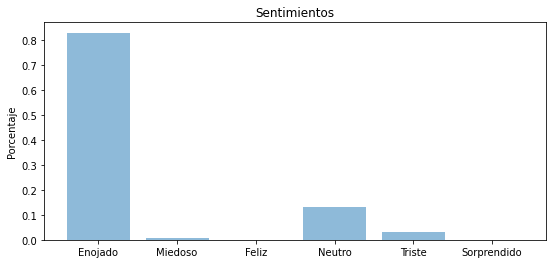

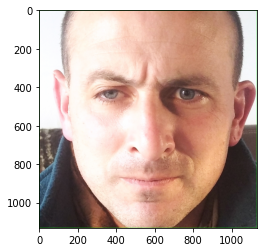

In [13]:
if __name__ == '__main__':
    cara('leo.jpg')

from tensorflow.keras.preprocessing import image

file = 'cara_cortada.jpg'
imagen_cortada = image.load_img(file)
img = image.load_img(file, color_mode="grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255

emotions = emocion_model.predict(x)
emocion(emotions[0])

plt.imshow(imagen_cortada)
plt.show()